In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

%matplotlib inline

In [3]:
def read_data(filename, usecols=[2, 5, 8, 19, 20], dtype={'Primary Type': str, 'Arrest': bool, 'Latitude' : float, 'Longitude' : float}, **kwargs):

    data = pd.read_csv(filename, usecols=usecols, dtype=dtype, quotechar='"', index_col='Date', **kwargs)
    data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    return data

In [4]:
nrows = 100000
filename = '/Users/Elaad/Documents/Fun/DatAnalysis/datasets/Crimes_-_2001_to_present.csv'
crimedata = read_data(filename)

# Crimes as a function of time and date

Some assumptions certainly go into the believability of these plots.
For example:
* Listed information---particularly dates and times---are accurate (the overabundance of crimes on the first of the month casts doubt on this assumption)

In [40]:
allcrime_hourcounts = crimedata.index.hour.value_counts().astype(float)
homicide_hourcounts = crimedata[crimedata['Primary Type']=='HOMICIDE'].index.hour.value_counts().astype(float)

allcrime_weekdaycounts = crimedata.index.weekday.value_counts().astype(float)
homicide_weekdaycounts = crimedata[crimedata['Primary Type']=='HOMICIDE'].index.weekday.value_counts().astype(float)

allcrime_daycounts = crimedata.index.day.value_counts().astype(float)
homicide_daycounts = crimedata[crimedata['Primary Type']=='HOMICIDE'].index.day.value_counts().astype(float)

allcrime_monthcounts = crimedata.index.month.value_counts().astype(float)
homicide_monthcounts = crimedata[crimedata['Primary Type']=='HOMICIDE'].index.month.value_counts().astype(float)

allcrime_yearcounts = crimedata.index.year.value_counts().astype(float)
homicide_yearcounts = crimedata[crimedata['Primary Type']=='HOMICIDE'].index.year.value_counts().astype(float)

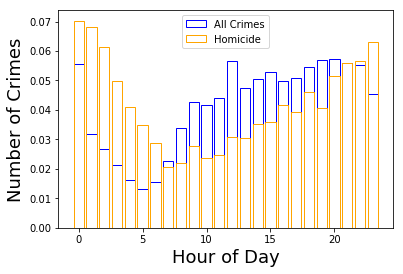

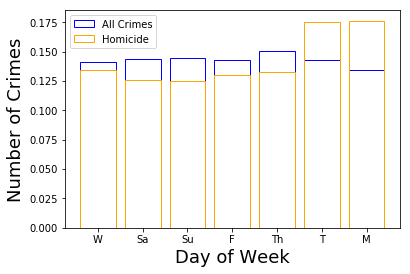

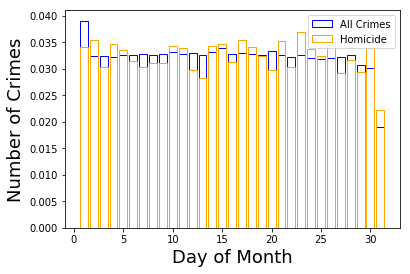

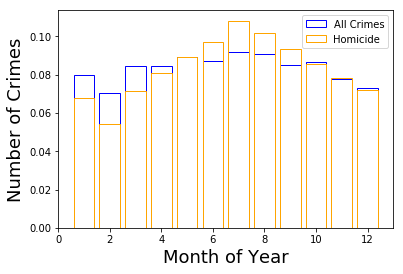

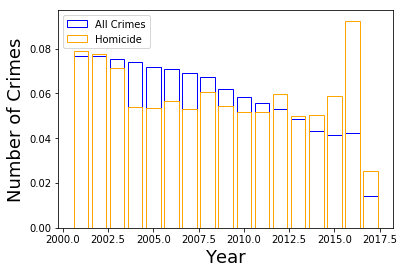

In [42]:
fig, ax = plt.subplots(1, 1)
ax.bar(allcrime_hourcounts.index, allcrime_hourcounts.values/allcrime_hourcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
ax.bar(homicide_hourcounts.index, homicide_hourcounts.values/homicide_hourcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
ax.set_xlabel('Hour of Day', fontsize=18)
ax.set_ylabel('Number of Crimes', fontsize=18)
plt.legend(loc='best')

weekdays = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']
fig, ax = plt.subplots(1, 1)
ax.bar(allcrime_weekdaycounts.index, allcrime_weekdaycounts.values/allcrime_weekdaycounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue', tick_label=weekdays)
ax.bar(homicide_weekdaycounts.index, homicide_weekdaycounts.values/homicide_weekdaycounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange', tick_label=weekdays)
ax.set_xlabel('Day of Week', fontsize=18)
ax.set_ylabel('Number of Crimes', fontsize=18)
plt.legend(loc='best')

fig, ax = plt.subplots(1, 1)
ax.bar(allcrime_daycounts.index, allcrime_daycounts.values/allcrime_daycounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
ax.bar(homicide_daycounts.index, homicide_daycounts.values/homicide_daycounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
ax.set_xlabel('Day of Month', fontsize=18)
ax.set_ylabel('Number of Crimes', fontsize=18)
plt.legend(loc='best')

fig, ax = plt.subplots(1, 1)
ax.bar(allcrime_monthcounts.index, allcrime_monthcounts.values/allcrime_monthcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
ax.bar(homicide_monthcounts.index, homicide_monthcounts.values/homicide_monthcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
ax.set_xlabel('Month of Year', fontsize=18)
ax.set_ylabel('Number of Crimes', fontsize=18)
plt.legend(loc='best')

fig, ax = plt.subplots(1, 1)
ax.bar(allcrime_yearcounts.index, allcrime_yearcounts.values/allcrime_yearcounts.values.sum(), label='All Crimes', facecolor='none', edgecolor='blue')
ax.bar(homicide_yearcounts.index, homicide_yearcounts.values/homicide_yearcounts.values.sum(), label='Homicide', facecolor='none', edgecolor='orange')
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number of Crimes', fontsize=18)
plt.legend(loc='best')

# Do crimes behave as a Poisson process?

Let's use 2007 as a "typical" year, since it's in the middle of a steady homicide rate.

There were an average of 1.23 HOMICIDE crimes per day in 2007
There were an average of 233.30 THEFT crimes per day in 2007
There were an average of 218.06 BATTERY crimes per day in 2007


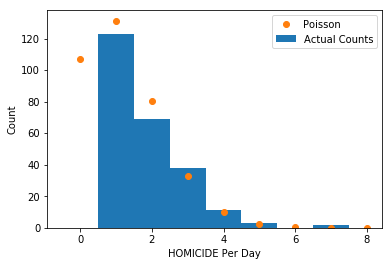

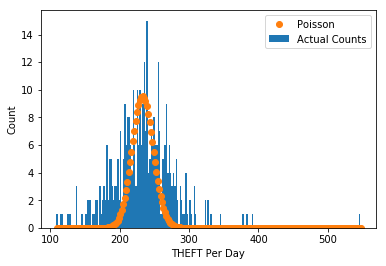

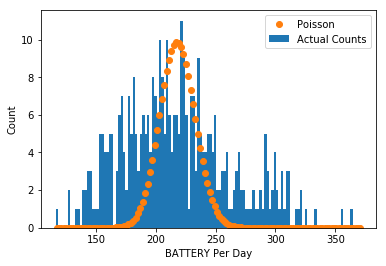

In [70]:
crimes2007 = crimedata[crimedata.index.year==2007]
for crimetype in ['HOMICIDE', 'THEFT', 'BATTERY']:
    subset2007 = crimes2007[crimes2007['Primary Type']==crimetype]
    subset_mean = len(subset2007)/365.0
    print 'There were an average of {:.2f} '.format(subset_mean)+crimetype+' crimes per day in 2007'
    subset_counts2007 = subset2007.index.dayofyear.value_counts()

    fig, ax = plt.subplots(1, 1)
    if len(subset2007)>1000.0:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 2.0)
    else:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 1.0)
    ax.hist(subset_counts2007.values, bins=bins, label='Actual Counts')
    ax.plot(bins+0.5, 365.0*ss.poisson.pmf(bins+0.5, subset_mean), 'o', label='Poisson')
    ax.set_xlabel(crimetype+' Per Day')
    ax.set_ylabel('Count')
    plt.legend(loc='best')

array([7, 7, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [65]:
len(subset2007)

79591